In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
import math
import matplotlib.dates as mdates
import datetime as dt 

import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import * 
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

from pandas.plotting import autocorrelation_plot

from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller

import yfinance as yf
from pandas_datareader import data

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

2022-10-31 16:03:17.721653: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
nflx = yf.download('NFLX', start='2017-10-28', end='2022-10-28')
nflx


[*********************100%***********************]  1 of 1 completed


Open        High         Low       Close   Adj Close  \
Date                                                                     
2017-10-30  199.619995  201.100006  197.070007  198.369995  198.369995   
2017-10-31  198.210007  198.589996  195.220001  196.429993  196.429993   
2017-11-01  197.240005  199.199997  196.000000  198.000000  198.000000   
2017-11-02  197.449997  199.440002  197.089996  199.320007  199.320007   
2017-11-03  199.800003  200.550003  197.990005  200.009995  200.009995   
...                ...         ...         ...         ...         ...   
2022-10-21  268.950012  290.750000  265.679993  289.570007  289.570007   
2022-10-24  290.230011  290.489990  280.359985  282.450012  282.450012   
2022-10-25  286.950012  297.589996  285.549988  291.019989  291.019989   
2022-10-26  290.040009  305.630005  288.040009  298.619995  298.619995   
2022-10-27  298.329987  305.209991  294.779999  296.940002  296.940002   

              Volume  
Date                  
2017-10-30   5439600  
2017-10-31   5518600  
2017-11-01   5017400  
2017-11-02   3606300  
2017-11-03   3678800  
...              ...  
2022-10-21  24862700  
2022-10-24  13326400  
2022-10-25  15100700  
2022-10-26  15714100  
2022-10-27  14612600  

[1258 rows x 6 columns]

mean : 384.3837834708452


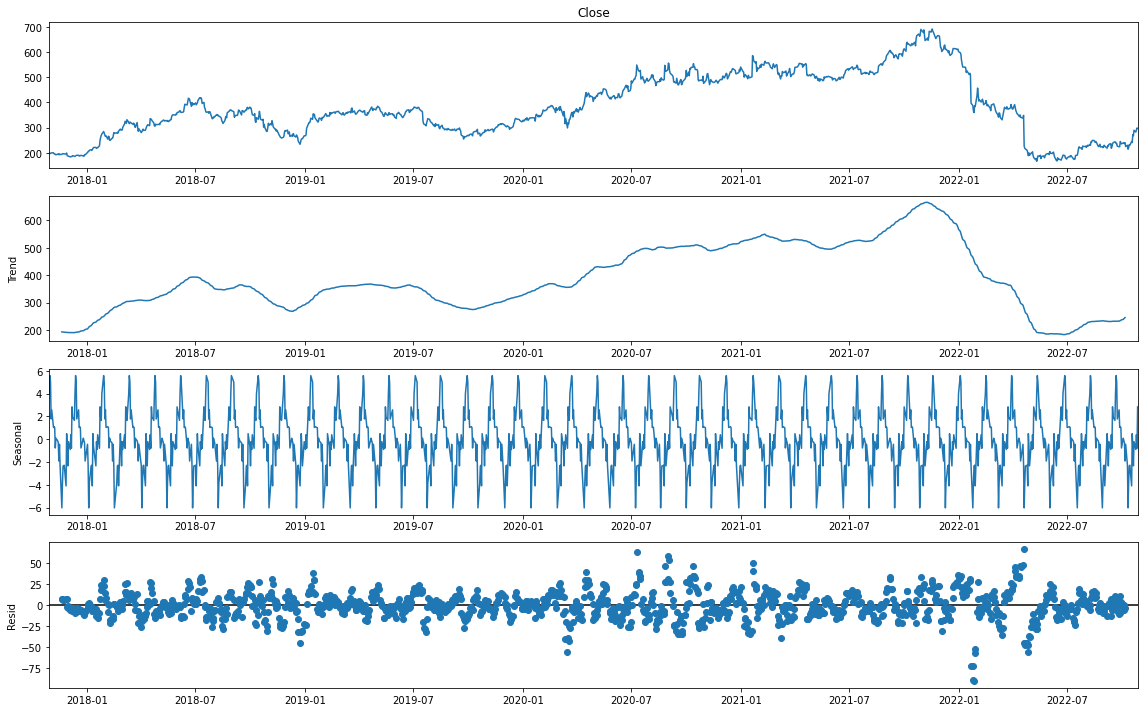

In [11]:
import statsmodels.api as sm
print('mean :' , nflx.Close.mean())
res = sm.tsa.seasonal_decompose(nflx.Close, period=30)
resplot = res.plot()
resplot.set_size_inches((16,10))
resplot.tight_layout()



<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

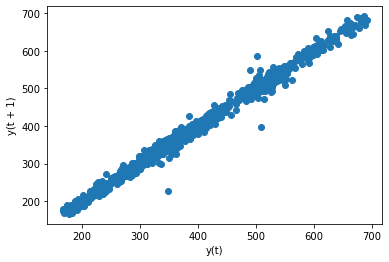

In [5]:
lag_plot(nflx.Close)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

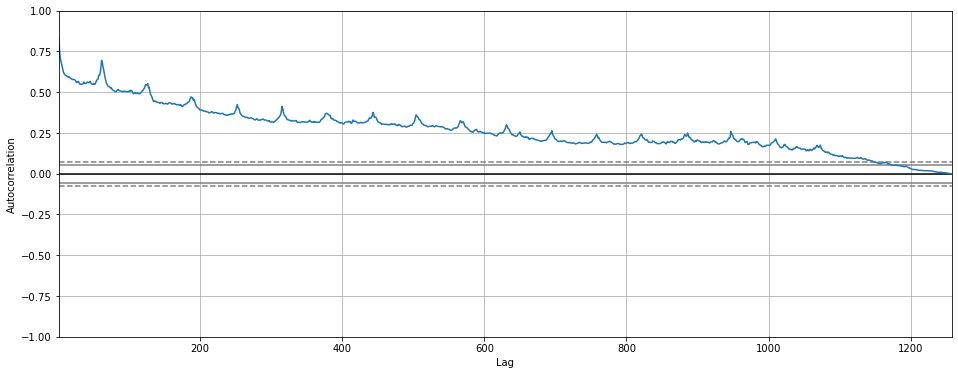

In [14]:
plt.figure(figsize=(16,6))
autocorrelation_plot(nflx)

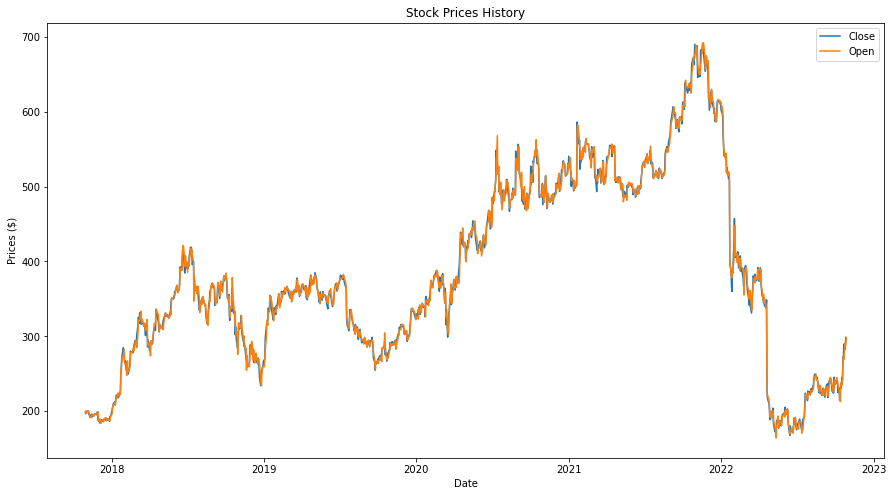

In [6]:
plt.figure(figsize=(16, 8))
plt.title('Stock Prices History')
plt.plot(nflx['Close'], label='Close')
plt.plot(nflx['Open'], label='Open')
plt.xlabel('Date')
plt.ylabel('Prices ($)')
plt.legend()

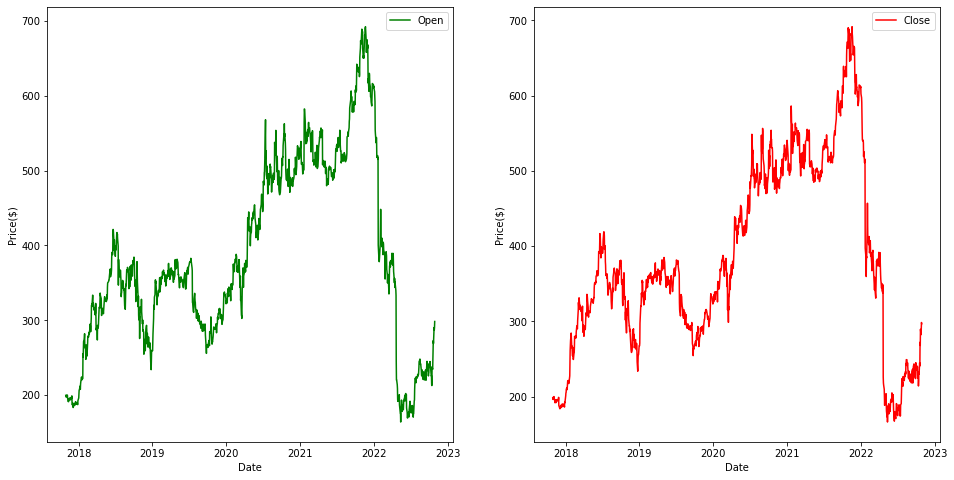

In [16]:
fg, ax =plt.subplots(1,2,figsize=(16,8))
ax[0].plot(nflx['Open'],label='Open',color='green')
ax[0].set_xlabel('Date',size=10)
ax[0].set_ylabel('Price($)',size=10)
ax[0].legend()
ax[1].plot(nflx['Close'],label='Close',color='red')
ax[1].set_xlabel('Date',size=10)
ax[1].set_ylabel('Price($)',size=10)
ax[1].legend()
plt.show()

In [ ]:
################ data prep for lsmt ################

close_prices = df['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)

train_data = df[0: training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

test_data = df[training_data_len-60: , : ]

x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

################ data prep for lsmt ################

<!-- train -->
Line 1–2: Extract the closing prices from the acquired stock data and convert it to a number series.

Line 3: Calculate the data size for 80% of the dataset. The math.ceil method is to ensure the data size is rounded up to an integer.

Line 5–6: Use the Scikit-Learn MinMaxScaler to normalize all our stock data ranging from 0 to 1. We also reshape our normalized data into a two-dimensional array.

Line 7: Set apart the first 80% of the stock data as the training set.

Line 9–10: Create an empty list for a sequence of feature data (x_train) and a sequence of label data (y_train).

Line 12–14: Create a 60-days window of historical prices (i-60) as our feature data (x_train) and the following 60-days window as label data (y_train).

Line 16–17: Convert the feature data (x_train) and label data (y_train) into Numpy array as it is the data format accepted by the Tensorflow when training a neural network model. Reshape again the x_train and y_train into a three-dimensional array as part of the requirement to train a LSTM model.

<!-- test -->
Line 1: Extract the closing prices from our normalized dataset (the last 20% of the dataset).

Line 2–6: Similar to the training set, we will have to create feature data (x_test) and label data (y_test)from our test set.

Line 8–9: Convert the feature data (x_test) and label data (y_test) into Numpy array. Reshape again the x_test and y_test into a three-dimensional array

In [35]:
def test(df):
    close_prices = df['Close']
    values = close_prices.values
    training_data_len = math.ceil(len(values)* 0.8)
    
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(values.reshape(-1,1))
    
    train_data = scaled_data[0: training_data_len, :]
    
    x_train = []
    y_train = []
    
    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i, 0])
        
    x_train, y_train = np.array(x_train), np.array(y_train)
    
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    
    
    test_data = scaled_data[training_data_len-60: , : ]
    x_test = []
    y_test = values[training_data_len:]
    
    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])
    
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    
    
    model = keras.Sequential()
    model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(layers.LSTM(100, return_sequences=False))
    model.add(layers.Dense(50))
    model.add(layers.Dense(25))
    model.add(layers.Dense(1))
    model.summary()
    
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(x_train, y_train, batch_size= 1, epochs=10)
    
    
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)
    rmse = np.sqrt(np.mean(predictions - y_test)**2)
    print('rmse', rmse)
    
    
    data = df.filter(['Close'])
    train = data[:training_data_len]
    validation = data[training_data_len:]
    validation['Predicted'] = predictions
    plt.figure(figsize=(16,8))
    plt.title('Model')
    plt.xlabel('Date')
    plt.ylabel('Close Price USD ($)')
    plt.plot(train)
    plt.plot(validation[['Close', 'Predicted']])
    plt.legend(['Train', 'Val', 'Predicted'], loc='lower right')
    plt.show()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 60, 100)           40800     
                                                                 
 lstm_17 (LSTM)              (None, 100)               80400     
                                                                 
 dense_32 (Dense)            (None, 50)                5050      
                                                                 
 dense_33 (Dense)            (None, 25)                1275      
                                                                 
 dense_34 (Dense)            (None, 1)                 26        
                                                                 
Total params: 127,551
Trainable params: 127,551
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
947/947 [============================

/var/folders/3k/_2nrg4_92wv7dq340pkrhc5h0000gn/T/ipykernel_70584/4007169833.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predicted'] = predictions


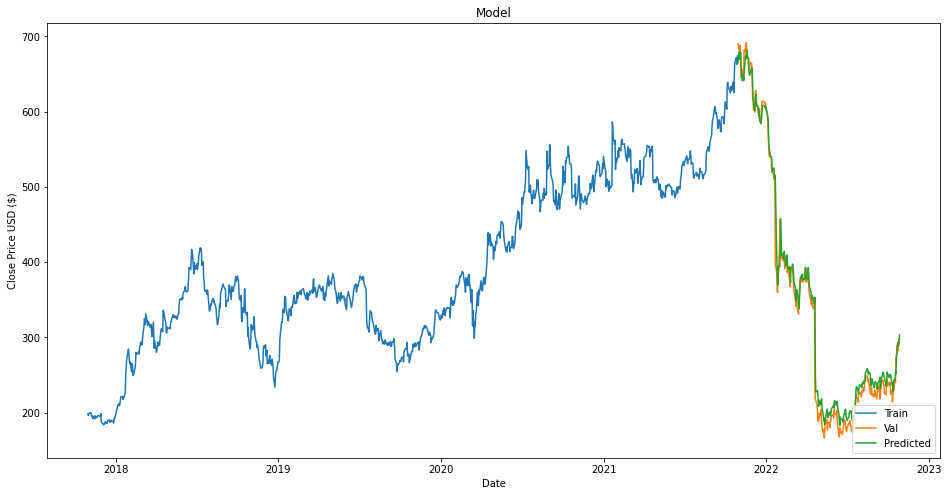

In [36]:
test(nflx)

In [33]:
def test2(df):
    close_prices = df['Close']
    values = close_prices.values
    training_data_len = math.ceil(len(values)* 0.8)
    
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(values.reshape(-1,1))
    
    train_data = scaled_data[0: training_data_len, :]
    
    x_train = []
    y_train = []
    
    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i, 0])
        
    x_train, y_train = np.array(x_train), np.array(y_train)
    
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    
    
    test_data = scaled_data[training_data_len-60: , : ]
    x_test = []
    y_test = values[training_data_len:]
    
    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])
    
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    
    
    model = keras.Sequential()
    model.add(layers.LSTM(200, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(layers.LSTM(100, return_sequences=False))
    model.add(layers.Dense(75, activation='relu'))
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dense(25, activation='relu'))
    model.add(layers.Dense(1, activation='relu'))
    model.summary()
    
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(x_train, y_train, batch_size= 1, epochs=10)
    
    
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)
    rmse = np.sqrt(np.mean(predictions - y_test)**2)
    print('rmse', rmse)
    
    
    data = df.filter(['Close'])
    train = data[:training_data_len]
    validation = data[training_data_len:]
    validation['Predicted'] = predictions
    plt.figure(figsize=(16,8))
    plt.title('Model')
    plt.xlabel('Date')
    plt.ylabel('Close Price USD ($)')
    plt.plot(train)
    plt.plot(validation[['Close', 'Predicted']])
    plt.legend(['Train', 'Val', 'Predicted'], loc='lower right')
    plt.show()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 60, 200)           161600    
                                                                 
 lstm_15 (LSTM)              (None, 100)               120400    
                                                                 
 dense_28 (Dense)            (None, 75)                7575      
                                                                 
 dense_29 (Dense)            (None, 50)                3800      
                                                                 
 dense_30 (Dense)            (None, 25)                1275      
                                                                 
 dense_31 (Dense)            (None, 1)                 26        
                                                                 
Total params: 294,676
Trainable params: 294,676
Non-tr

/var/folders/3k/_2nrg4_92wv7dq340pkrhc5h0000gn/T/ipykernel_70584/1077161971.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predicted'] = predictions


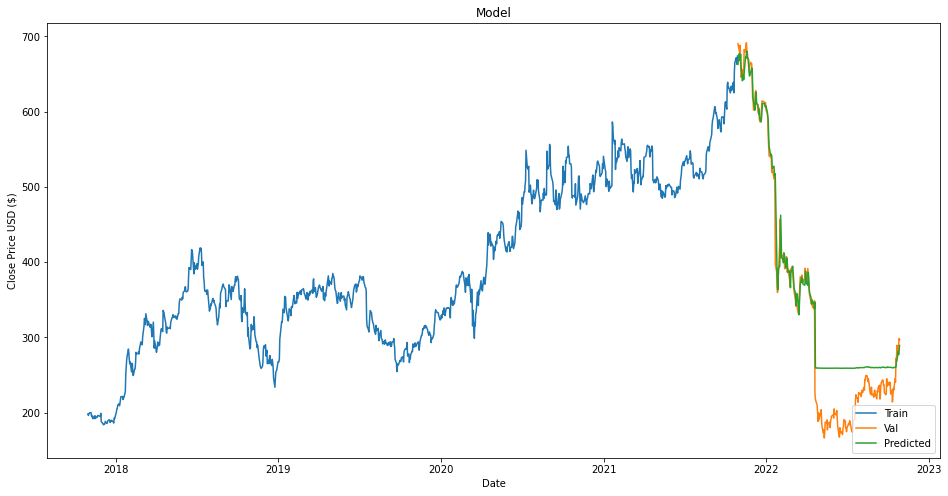

CPU times: user 10min 19s, sys: 2min 15s, total: 12min 34s
Wall time: 3min 49s


In [34]:
%%time
test2(nflx)

In [42]:
def test3(df):
    close_prices = df['Close']
    values = close_prices.values
    training_data_len = math.ceil(len(values)* 0.8)
    
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(values.reshape(-1,1))
    
    train_data = scaled_data[0: training_data_len, :]
    
    x_train = []
    y_train = []
    
    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i, 0])
        
    x_train, y_train = np.array(x_train), np.array(y_train)
    
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    
    
    test_data = scaled_data[training_data_len-60: , : ]
    x_test = []
    y_test = values[training_data_len:]
    
    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])
    
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    
    
    model = Sequential()
    
    model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50,return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50,return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.summary()
    
    model.compile(optimizer='adam',loss='mean_squared_error')
    model.fit(x_train,y_train,epochs=100,batch_size=32)
    
    
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)
    
    rmse = np.sqrt(np.mean(predictions - y_test)**2)
    print('rmse', rmse)
    
    
    data = df.filter(['Close'])
    train = data[:training_data_len]
    validation = data[training_data_len:]
    validation['Predicted'] = predictions
    plt.figure(figsize=(16,8))
    plt.title('Model')
    plt.xlabel('Date')
    plt.ylabel('Close Price USD ($)')
    plt.plot(train)
    plt.plot(validation[['Close', 'Predicted']])
    plt.legend(['Train', 'Val', 'Predicted'], loc='lower right')
    plt.show()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 60, 50)            10400     
                                                                 
 dropout_8 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_27 (LSTM)              (None, 60, 50)            20200     
                                                                 
 dropout_9 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_28 (LSTM)              (None, 60, 50)            20200     
                                                                 
 dropout_10 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_29 (LSTM)              (None, 50)              

30/30 [==============================] - 3s 90ms/step - loss: 0.0013
Epoch 82/100
30/30 [==============================] - 3s 84ms/step - loss: 0.0013
Epoch 83/100
30/30 [==============================] - 2s 79ms/step - loss: 0.0015
Epoch 84/100
30/30 [==============================] - 2s 73ms/step - loss: 0.0014
Epoch 85/100
30/30 [==============================] - 3s 94ms/step - loss: 0.0014
Epoch 86/100
30/30 [==============================] - 3s 95ms/step - loss: 0.0013
Epoch 87/100
30/30 [==============================] - 2s 74ms/step - loss: 0.0013
Epoch 88/100
30/30 [==============================] - 2s 82ms/step - loss: 0.0013
Epoch 89/100
30/30 [==============================] - 2s 82ms/step - loss: 0.0012
Epoch 90/100
30/30 [==============================] - 3s 92ms/step - loss: 0.0013
Epoch 91/100
30/30 [==============================] - 3s 104ms/step - loss: 0.0013
Epoch 92/100
30/30 [==============================] - 3s 89ms/step - loss: 0.0013
Epoch 93/100
30/30 [========

/var/folders/3k/_2nrg4_92wv7dq340pkrhc5h0000gn/T/ipykernel_70584/2635734954.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predicted'] = predictions


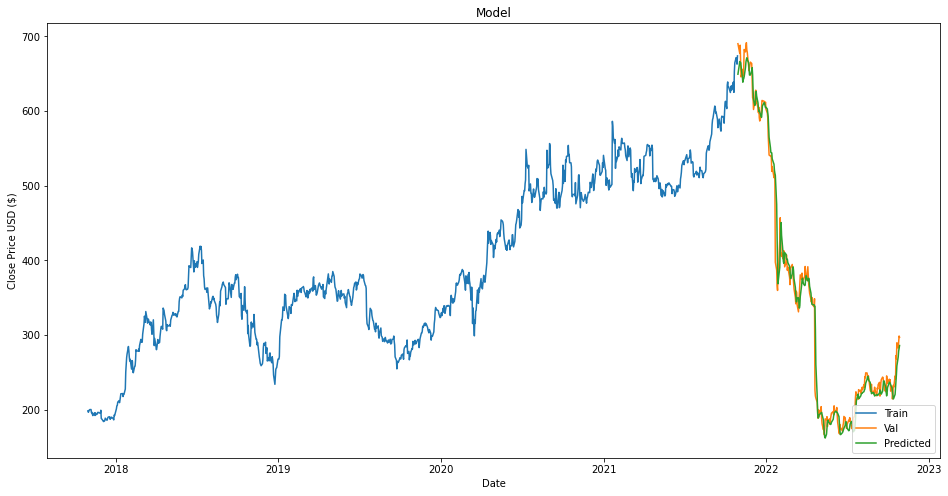

CPU times: user 9min 27s, sys: 2min 11s, total: 11min 39s
Wall time: 4min 11s


In [43]:
%%time
test3(nflx)

In [46]:
def test4(df):
    close_prices = df['Close']
    values = close_prices.values
    training_data_len = math.ceil(len(values)* 0.8)
    
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(values.reshape(-1,1))
    
    train_data = scaled_data[0: training_data_len, :]
    
    x_train = []
    y_train = []
    
    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i, 0])
        
    x_train, y_train = np.array(x_train), np.array(y_train)
    
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    
    
    test_data = scaled_data[training_data_len-60: , : ]
    x_test = []
    y_test = values[training_data_len:]
    
    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])
    
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    
    
    model = Sequential()
    
    model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50,return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50,return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.summary()
    
    model.compile(optimizer='adam',loss='mean_squared_error')
    model.fit(x_train,y_train,epochs=200,batch_size=32)
    
    
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)
    
    rmse = np.sqrt(np.mean(predictions - y_test)**2)
    print('rmse', rmse)
    
    
    data = df.filter(['Close'])
    train = data[:training_data_len]
    validation = data[training_data_len:]
    validation['Predicted'] = predictions
    plt.figure(figsize=(16,8))
    plt.title('Model')
    plt.xlabel('Date')
    plt.ylabel('Close Price USD ($)')
    plt.plot(train)
    plt.plot(validation[['Close', 'Predicted']])
    plt.legend(['Train', 'Val', 'Predicted'], loc='lower right')
    plt.show()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_34 (LSTM)              (None, 60, 50)            10400     
                                                                 
 dropout_16 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_35 (LSTM)              (None, 60, 50)            20200     
                                                                 
 dropout_17 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_36 (LSTM)              (None, 60, 50)            20200     
                                                                 
 dropout_18 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_37 (LSTM)              (None, 50)              

30/30 [==============================] - 2s 56ms/step - loss: 0.0015
Epoch 82/200
30/30 [==============================] - 2s 57ms/step - loss: 0.0015
Epoch 83/200
30/30 [==============================] - 2s 64ms/step - loss: 0.0014
Epoch 84/200
30/30 [==============================] - 2s 58ms/step - loss: 0.0015
Epoch 85/200
30/30 [==============================] - 2s 57ms/step - loss: 0.0015
Epoch 86/200
30/30 [==============================] - 2s 57ms/step - loss: 0.0014
Epoch 87/200
30/30 [==============================] - 2s 56ms/step - loss: 0.0014
Epoch 88/200
30/30 [==============================] - 2s 57ms/step - loss: 0.0014
Epoch 89/200
30/30 [==============================] - 2s 56ms/step - loss: 0.0017
Epoch 90/200
30/30 [==============================] - 2s 56ms/step - loss: 0.0014
Epoch 91/200
30/30 [==============================] - 2s 56ms/step - loss: 0.0013
Epoch 92/200
30/30 [==============================] - 2s 57ms/step - loss: 0.0013
Epoch 93/200
30/30 [=========

30/30 [==============================] - 2s 57ms/step - loss: 8.8161e-04
Epoch 179/200
30/30 [==============================] - 2s 58ms/step - loss: 8.1018e-04
Epoch 180/200
30/30 [==============================] - 2s 59ms/step - loss: 9.0024e-04
Epoch 181/200
30/30 [==============================] - 2s 58ms/step - loss: 8.3151e-04
Epoch 182/200
30/30 [==============================] - 2s 57ms/step - loss: 9.4740e-04
Epoch 183/200
30/30 [==============================] - 2s 57ms/step - loss: 9.3661e-04
Epoch 184/200
30/30 [==============================] - 2s 57ms/step - loss: 8.5537e-04
Epoch 185/200
30/30 [==============================] - 2s 66ms/step - loss: 9.9642e-04
Epoch 186/200
30/30 [==============================] - 2s 59ms/step - loss: 0.0010
Epoch 187/200
30/30 [==============================] - 2s 57ms/step - loss: 8.7238e-04
Epoch 188/200
30/30 [==============================] - 2s 57ms/step - loss: 7.9560e-04
Epoch 189/200
30/30 [==============================] - 2s 57m

/var/folders/3k/_2nrg4_92wv7dq340pkrhc5h0000gn/T/ipykernel_70584/4218929954.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predicted'] = predictions


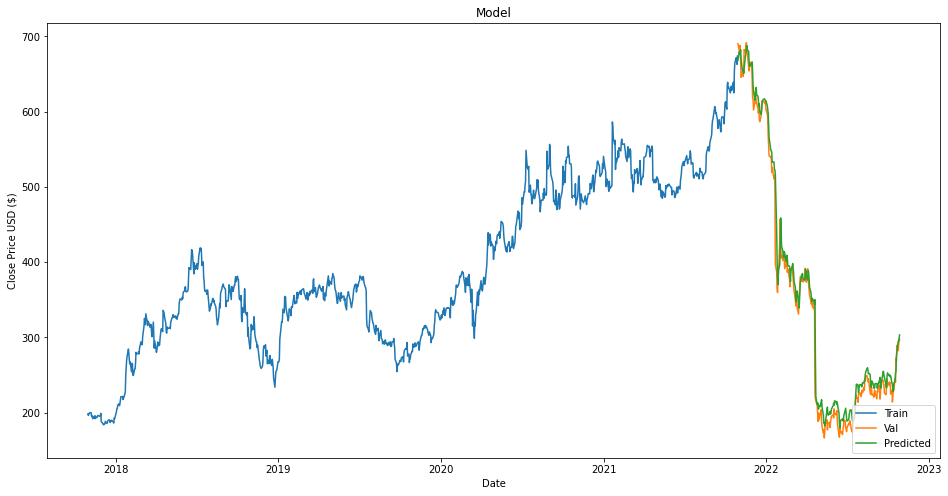

CPU times: user 13min 54s, sys: 2min 28s, total: 16min 22s
Wall time: 6min 13s


In [47]:
%%time
test4(nflx)

In [ ]:
# test3 but changing the window size from 60 to 365 for training and next 30 days for test 

In [ ]:
# df / 1258
# 80% = 1006
# x_train = df[0,len(df)*0.8]
# x_test = df[len(df)*0.8,:]

In [92]:
def testwindow(df):
    close_prices = df['Close']
    values = close_prices.values
    training_data_len = math.ceil(len(values)* 0.8)
    
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(values.reshape(-1,1))
    
    train_data = scaled_data[0: training_data_len, :]
    
    x_train = []
    y_train = []
    
    for i in range(365, len(train_data)):
        x_train.append(train_data[i-365:i, 0])
        y_train.append(train_data[i, 0])
        
    x_train, y_train = np.array(x_train), np.array(y_train)
    
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    
    
    test_data = scaled_data[training_data_len-365: , : ]
    x_test = []
    y_test = values[training_data_len:]
    
    for i in range(365, len(test_data)):
        x_test.append(test_data[i-365:i, 0])
    
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    
    
    model = Sequential()
    
    model.add(LSTM(units=50,return_sequences=True,input_shape=(365, 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50,return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50,return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.summary()
    
    model.compile(optimizer='adam',loss='mean_squared_error')
    model.fit(x_train,y_train,epochs=10,batch_size=32)
    
    
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)
#     print(predictions)
    
    rmse = np.sqrt(np.mean(predictions - y_test)**2)
    print('rmse', rmse)
    
    df2 = df
    data = df2.filter(['Close'])
    train = data[:training_data_len]
    data2 = df2.head(60)
    data2 = df2.filter(['Close'])
    validation = data[training_data_len:]
    validation = validation.head(60)
#     print(validation)
    validation['Predicted'] = predictions[0:60]
    plt.figure(figsize=(16,8))
    plt.title('Model')
    plt.xlabel('Date')
    plt.ylabel('Close Price USD ($)')
    plt.plot(train)
    plt.plot(validation[['Close', 'Predicted']])
    plt.legend(['Train', 'Val', 'Predicted'], loc='lower right')
    plt.show()

In [93]:
# change train/test
# split model and graphing 
# graph 30 days/ 10 ?
# return predictions as it is ? 
# plot first 60 or whatever want

In [94]:
# df2 = df.head(60)

In [95]:
# print()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_90 (LSTM)              (None, 365, 50)           10400     
                                                                 
 dropout_72 (Dropout)        (None, 365, 50)           0         
                                                                 
 lstm_91 (LSTM)              (None, 365, 50)           20200     
                                                                 
 dropout_73 (Dropout)        (None, 365, 50)           0         
                                                                 
 lstm_92 (LSTM)              (None, 365, 50)           20200     
                                                                 
 dropout_74 (Dropout)        (None, 365, 50)           0         
                                                                 
 lstm_93 (LSTM)              (None, 50)              

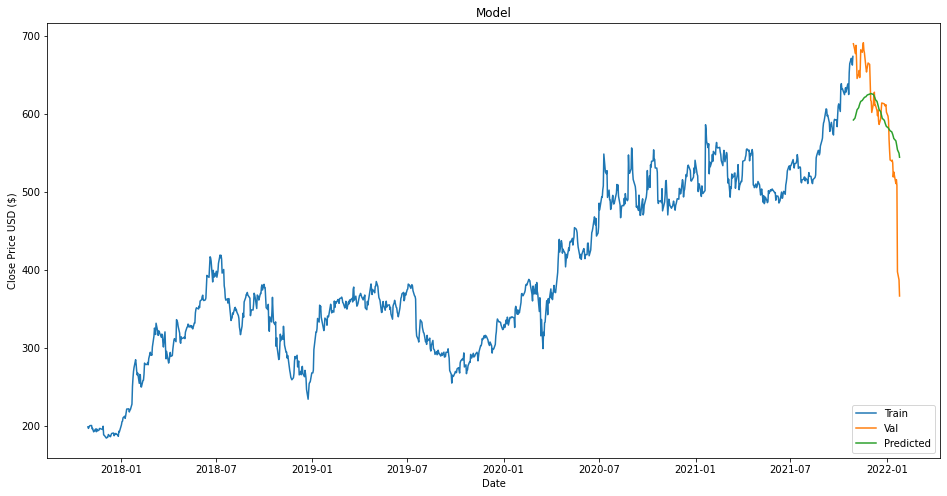

CPU times: user 3min 34s, sys: 41.4 s, total: 4min 16s
Wall time: 1min 38s


In [96]:
%%time
testwindow(nflx)

In [105]:
def splittest(df):
    close_prices = df['Close']
    values = close_prices.values
    training_data_len = math.ceil(len(values)* 0.8)
    
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(values.reshape(-1,1))
    
    train_data = scaled_data[0: training_data_len, :]
    
    x_train = []
    y_train = []
    
    for i in range(365, len(train_data)):
        x_train.append(train_data[i-365:i, 0])
        y_train.append(train_data[i, 0])
        
    x_train, y_train = np.array(x_train), np.array(y_train)
    
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    
    
    test_data = scaled_data[training_data_len-365: , : ]
    x_test = []
    y_test = values[training_data_len:]
    
    for i in range(365, len(test_data)):
        x_test.append(test_data[i-365:i, 0])
    
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    
    
    model = Sequential()
    
    model.add(LSTM(units=50,return_sequences=True,input_shape=(365, 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50,return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50,return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units=25))
    model.add(Dense(units=1))
    model.summary()
    
    model.compile(optimizer='adam',loss='mean_squared_error')
    model.fit(x_train,y_train,epochs=10,batch_size=32)
    
    
    apredictions = model.predict(x_test)
    apredictions = scaler.inverse_transform(apredictions)
    
    rmse = np.sqrt(np.mean(apredictions - y_test)**2)
    print('rmse', rmse)
    
    

In [106]:
splittest(nflx)

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_102 (LSTM)             (None, 365, 50)           10400     
                                                                 
 dropout_84 (Dropout)        (None, 365, 50)           0         
                                                                 
 lstm_103 (LSTM)             (None, 365, 50)           20200     
                                                                 
 dropout_85 (Dropout)        (None, 365, 50)           0         
                                                                 
 lstm_104 (LSTM)             (None, 365, 50)           20200     
                                                                 
 dropout_86 (Dropout)        (None, 365, 50)           0         
                                                                 
 lstm_105 (LSTM)             (None, 50)              

In [107]:
nflx

Open        High         Low       Close   Adj Close  \
Date                                                                     
2017-10-30  199.619995  201.100006  197.070007  198.369995  198.369995   
2017-10-31  198.210007  198.589996  195.220001  196.429993  196.429993   
2017-11-01  197.240005  199.199997  196.000000  198.000000  198.000000   
2017-11-02  197.449997  199.440002  197.089996  199.320007  199.320007   
2017-11-03  199.800003  200.550003  197.990005  200.009995  200.009995   
...                ...         ...         ...         ...         ...   
2022-10-21  268.950012  290.750000  265.679993  289.570007  289.570007   
2022-10-24  290.230011  290.489990  280.359985  282.450012  282.450012   
2022-10-25  286.950012  297.589996  285.549988  291.019989  291.019989   
2022-10-26  290.040009  305.630005  288.040009  298.619995  298.619995   
2022-10-27  298.329987  305.209991  294.779999  296.940002  296.940002   

              Volume  
Date                  
2017-10-30   5439600  
2017-10-31   5518600  
2017-11-01   5017400  
2017-11-02   3606300  
2017-11-03   3678800  
...              ...  
2022-10-21  24862700  
2022-10-24  13326400  
2022-10-25  15100700  
2022-10-26  15714100  
2022-10-27  14612600  

[1258 rows x 6 columns]

In [108]:
close_prices = nflx['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))

train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(365, len(train_data)):
    x_train.append(train_data[i-365:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


test_data = scaled_data[training_data_len-365: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(365, len(test_data)):
    x_test.append(test_data[i-365:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [109]:
%%time
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(100))
model.add(layers.Dense(50))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()


# model.add(LSTM(units=50,return_sequences=True,input_shape=(365, 1)))
# model.add(Dropout(0.2))
# model.add(LSTM(units=50,return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(units=50,return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(units=50))
# model.add(Dropout(0.2))
# model.add(Dense(units=25))
# model.add(Dense(units=1))
# model.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_106 (LSTM)             (None, 365, 100)          40800     
                                                                 
 lstm_107 (LSTM)             (None, 100)               80400     
                                                                 
 dense_58 (Dense)            (None, 100)               10100     
                                                                 
 dense_59 (Dense)            (None, 50)                5050      
                                                                 
 dense_60 (Dense)            (None, 25)                1275      
                                                                 
 dense_61 (Dense)            (None, 1)                 26        
                                                                 
Total params: 137,651
Trainable params: 137,651
Non-t

In [110]:
%%time
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 32, epochs=20)

Epoch 1/20
21/21 [==============================] - 12s 402ms/step - loss: 0.0310
Epoch 2/20
21/21 [==============================] - 11s 492ms/step - loss: 0.0040
Epoch 3/20
21/21 [==============================] - 7s 345ms/step - loss: 0.0016
Epoch 4/20
21/21 [==============================] - 7s 330ms/step - loss: 0.0014
Epoch 5/20
21/21 [==============================] - 8s 397ms/step - loss: 0.0014
Epoch 6/20
21/21 [==============================] - 8s 364ms/step - loss: 0.0016
Epoch 7/20
21/21 [==============================] - 7s 320ms/step - loss: 0.0013
Epoch 8/20
21/21 [==============================] - 7s 334ms/step - loss: 0.0012
Epoch 9/20
21/21 [==============================] - 7s 338ms/step - loss: 0.0012
Epoch 10/20
21/21 [==============================] - 7s 345ms/step - loss: 0.0014
Epoch 11/20
21/21 [==============================] - 9s 428ms/step - loss: 0.0012
Epoch 12/20
21/21 [==============================] - 8s 372ms/step - loss: 0.0013
Epoch 13/20
21/21 [====

In [111]:
%%time
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

8/8 [==============================] - 2s 102ms/step
CPU times: user 2.76 s, sys: 881 ms, total: 3.64 s
Wall time: 2.41 s


15.34677105785841

<timed exec>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


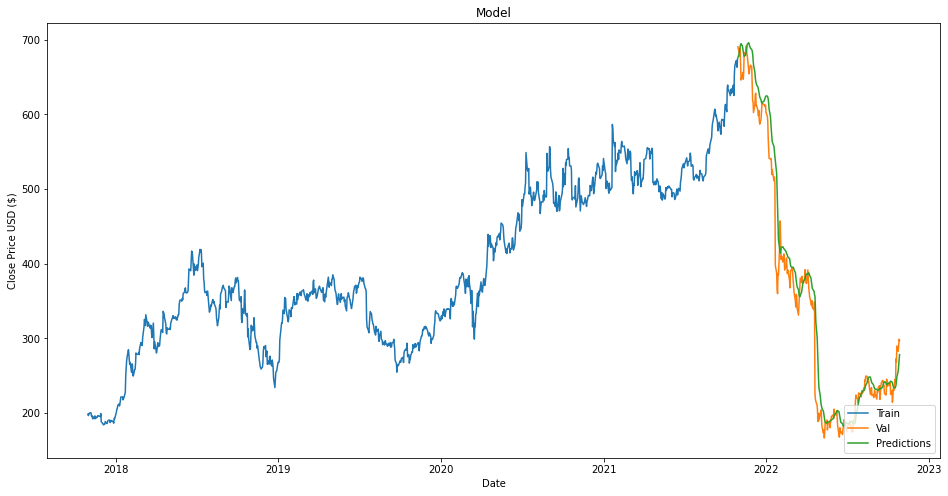

CPU times: user 206 ms, sys: 196 ms, total: 402 ms
Wall time: 638 ms


In [112]:
%%time
data = nflx.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
# tend line for next 7 days ?
# trend line for future based on last 14/21 days
# filter out 60-60 for each way 
# add predictions to nflx, use df to tablaeu 


# predict next week values using model 

In [135]:
nflx['Close'].iloc[-60:]

Date
2022-08-04    229.910004
2022-08-05    226.779999
2022-08-08    233.490005
2022-08-09    229.940002
2022-08-10    244.110001
2022-08-11    242.699997
2022-08-12    249.300003
2022-08-15    249.110001
2022-08-16    245.690002
2022-08-17    241.149994
2022-08-18    245.169998
2022-08-19    241.160004
2022-08-22    226.539993
2022-08-23    224.550003
2022-08-24    229.610001
2022-08-25    233.979996
2022-08-26    223.279999
2022-08-29    224.570007
2022-08-30    220.649994
2022-08-31    223.559998
2022-09-01    230.039993
2022-09-02    226.110001
2022-09-06    218.389999
2022-09-07    228.960007
2022-09-08    227.440002
2022-09-09    233.570007
2022-09-12    236.529999
2022-09-13    218.130005
2022-09-14    224.119995
2022-09-15    235.380005
2022-09-16    240.130005
2022-09-19    243.630005
2022-09-20    242.850006
2022-09-21    236.869995
2022-09-22    237.050003
2022-09-23    226.410004
2022-09-26    224.070007
2022-09-27    224.360001
2022-09-28    245.199997
2022-09-29    239.71

In [130]:
validation

Close  Predictions
Date                               
2021-10-29  690.309998   675.794739
2021-11-01  681.169983   681.668701
2021-11-02  677.719971   686.508118
2021-11-03  688.289978   689.956055
2021-11-04  668.400024   693.567688
...                ...          ...
2022-10-21  289.570007   248.157928
2022-10-24  282.450012   256.160675
2022-10-25  291.019989   263.598145
2022-10-26  298.619995   270.882782
2022-10-27  296.940002   278.127472

[251 rows x 2 columns]

In [132]:
pd.DataFrame(validation['Close'].iloc[-60:])

Close
Date                  
2022-08-04  229.910004
2022-08-05  226.779999
2022-08-08  233.490005
2022-08-09  229.940002
2022-08-10  244.110001
2022-08-11  242.699997
2022-08-12  249.300003
2022-08-15  249.110001
2022-08-16  245.690002
2022-08-17  241.149994
2022-08-18  245.169998
2022-08-19  241.160004
2022-08-22  226.539993
2022-08-23  224.550003
2022-08-24  229.610001
2022-08-25  233.979996
2022-08-26  223.279999
2022-08-29  224.570007
2022-08-30  220.649994
2022-08-31  223.559998
2022-09-01  230.039993
2022-09-02  226.110001
2022-09-06  218.389999
2022-09-07  228.960007
2022-09-08  227.440002
2022-09-09  233.570007
2022-09-12  236.529999
2022-09-13  218.130005
2022-09-14  224.119995
2022-09-15  235.380005
2022-09-16  240.130005
2022-09-19  243.630005
2022-09-20  242.850006
2022-09-21  236.869995
2022-09-22  237.050003
2022-09-23  226.410004
2022-09-26  224.070007
2022-09-27  224.360001
2022-09-28  245.199997
2022-09-29  239.710007
2022-09-30  235.440002
2022-10-03  239.039993
2022-10-04  240.740005
2022-10-05  236.729996
2022-10-06  240.020004
2022-10-07  224.750000
2022-10-10  229.979996
2022-10-11  214.289993
2022-10-12  220.869995
2022-10-13  232.509995
2022-10-14  230.000000
2022-10-17  245.100006
2022-10-18  240.860001
2022-10-19  272.380005
2022-10-20  268.160004
2022-10-21  289.570007
2022-10-24  282.450012
2022-10-25  291.019989
2022-10-26  298.619995
2022-10-27  296.940002

In [122]:
nflx

Open        High         Low       Close   Adj Close  \
Date                                                                     
2017-10-30  199.619995  201.100006  197.070007  198.369995  198.369995   
2017-10-31  198.210007  198.589996  195.220001  196.429993  196.429993   
2017-11-01  197.240005  199.199997  196.000000  198.000000  198.000000   
2017-11-02  197.449997  199.440002  197.089996  199.320007  199.320007   
2017-11-03  199.800003  200.550003  197.990005  200.009995  200.009995   
...                ...         ...         ...         ...         ...   
2022-10-21  268.950012  290.750000  265.679993  289.570007  289.570007   
2022-10-24  290.230011  290.489990  280.359985  282.450012  282.450012   
2022-10-25  286.950012  297.589996  285.549988  291.019989  291.019989   
2022-10-26  290.040009  305.630005  288.040009  298.619995  298.619995   
2022-10-27  298.329987  305.209991  294.779999  296.940002  296.940002   

              Volume  
Date                  
2017-10-30   5439600  
2017-10-31   5518600  
2017-11-01   5017400  
2017-11-02   3606300  
2017-11-03   3678800  
...              ...  
2022-10-21  24862700  
2022-10-24  13326400  
2022-10-25  15100700  
2022-10-26  15714100  
2022-10-27  14612600  

[1258 rows x 6 columns]

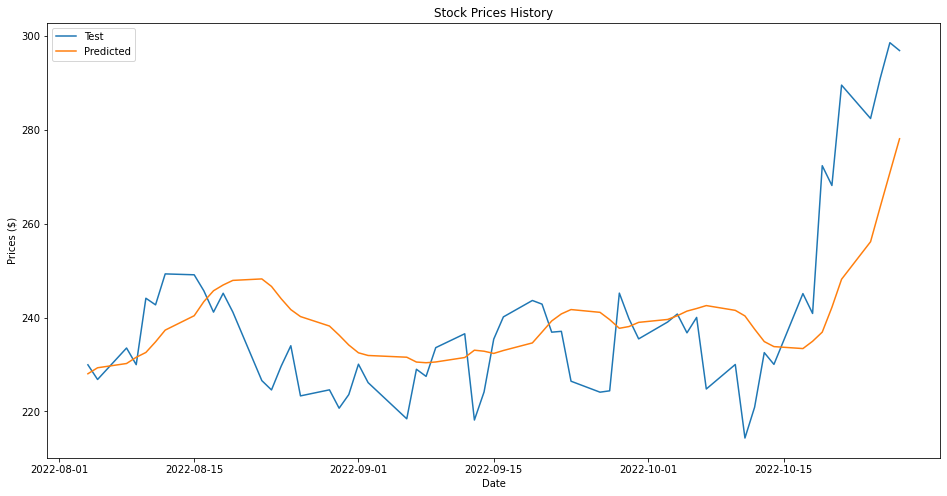

In [142]:
plt.figure(figsize=(16, 8))
plt.title('Stock Prices History')
# plt.plot(nflx['Close'].iloc[-60:-60], label='Train')
plt.plot(validation['Close'].iloc[-60:], label='Test')
plt.plot(validation['Predictions'].iloc[-60:], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Prices ($)')
plt.legend()

# graphing just last 60 days of test vs predictions 

# tablaeue maybe 

In [161]:
from pandas import Timestamp
start = Timestamp('2022-10-27')
end = Timestamp('2022-10-27')

all_dates = pd.date_range(start=start, end=end, freq='D')

# You can fill the "Value" column with any value you want. Here I filled with 0.
future = pd.DataFrame({'Date':all_dates , 'Value':[0]*len(all_dates)})
# future

future.index = pd.DatetimeIndex(future.Date, freq=None)
# future

future = future.drop(['Date'], axis=1)
future

Value
Date             
2022-10-27      0

In [162]:
future

Value
Date             
2022-10-27      0

In [159]:
# future['Value'] = model.predict(future)
# future['Value'] = scaler.inverse_transform(future['Value'])
# future

In [163]:
futurepredictions = model.predict(future)
futurepredictions = scaler.inverse_transform(futurepredictions)

1/1 [==============================] - 0s 48ms/step


In [167]:
futurepredictions

array([[213.9695]], dtype=float32)